<a href="https://colab.research.google.com/github/xiekg2020/DL_test/blob/main/helmet_detection_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Make sure you're using TensorFlow 1.15:**

In [21]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

# **Build the TF1 Object Detection API:**

In [22]:
%cd /content/
! pip install tf_slim
! git clone https://github.com/tensorflow/models.git

/content
fatal: destination path 'models' already exists and is not an empty directory.


In [23]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/'
os.environ['PYTHONPATH'] += ':/content/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection/utils/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection'

In [24]:
! apt-get install protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [25]:
%cd models/research
# Compile all the protobuf dependencies
! protoc object_detection/protos/*.proto --python_out=.
# Set up and install the object detection API
! cp object_detection/packages/tf1/setup.py .
! python -m pip install .
# Run a test to make sure setup is correct
! python object_detection/builders/model_builder_test.py

/content/models/research
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1660278 sha256=c92203267edd0645d9f4442c9a639570147c1e9ec58d40bb6177605e8561d7d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-r5pdkwmt/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


# **Export the trained model**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
%cd /content/
OUTPUT_DIR = '/content/drive/MyDrive/output_ssdlite_mobiledet_hard_hat'

/content


# **Evaluate the trained model**

Evaluating: /content/drive/MyDrive/validate_img/image_1.jpg
Evaluating: /content/drive/MyDrive/validate_img/image_2.jpg
Evaluating: /content/drive/MyDrive/validate_img/image_3.jpg
Evaluating: /content/drive/MyDrive/validate_img/image_4.jpg
Evaluating: /content/drive/MyDrive/validate_img/image_5.jpg
Evaluating: /content/drive/MyDrive/validate_img/image_6.jpg


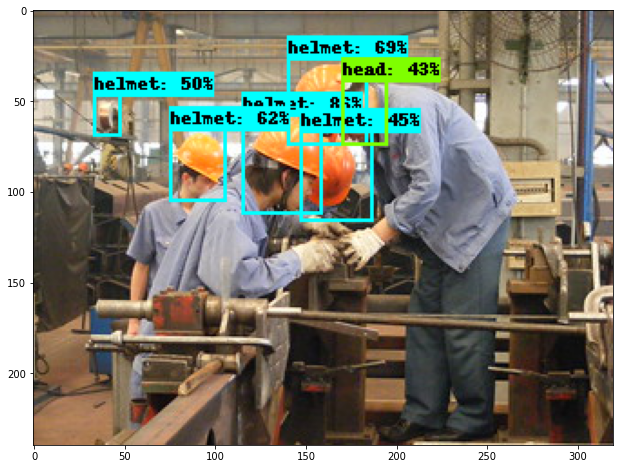

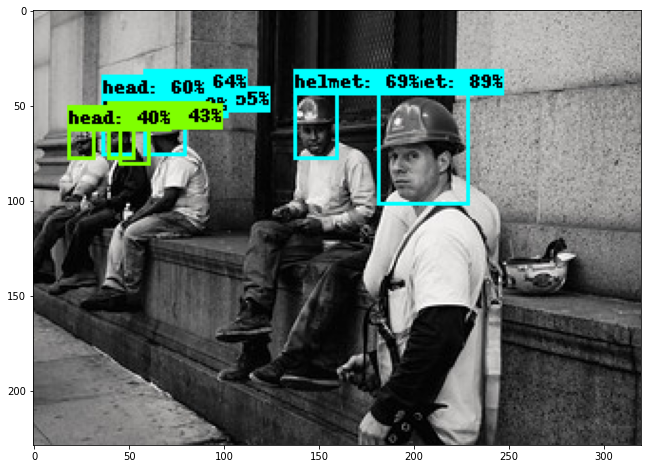

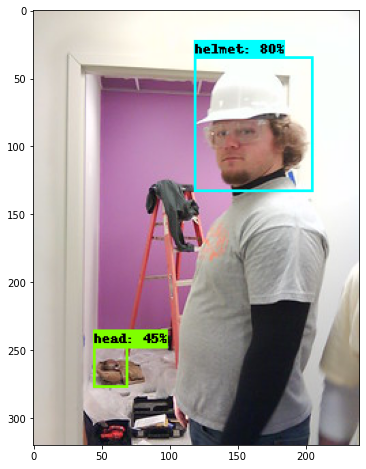

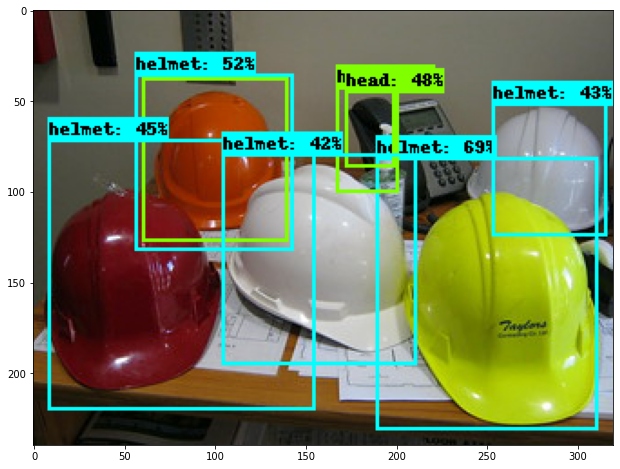

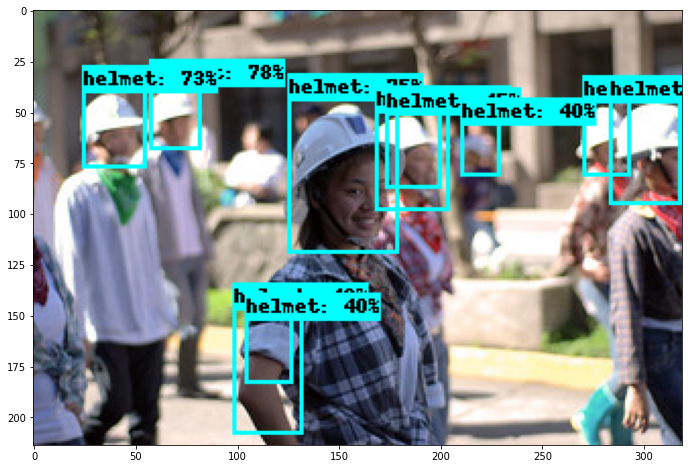

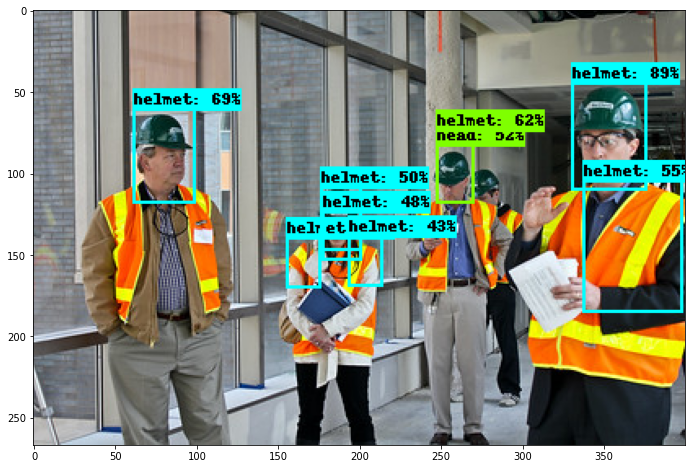

In [28]:
# Do a Quick Evaluation on the inference graph model.
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(OUTPUT_DIR+"/frozen_inference_graph.pb", 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loads labels
label_map = label_map_util.load_labelmap('/content/drive/MyDrive/output_ssdlite_mobiledet_hard_hat/labels.txt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=3, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

test_image_path = [os.path.join('/content/drive/MyDrive/validate_img', 'image_{}.jpg'.format(i)) for i in range(1, 7)]
for image_path in test_image_path:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
  # Run inference.
  output_dict = run_inference(detection_graph, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.4,
      line_thickness=2)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

# **Evaluate the TFlite model**

Evaluating: /content/drive/MyDrive/validate_img/image_1.jpg
Helmet 83.59375%
Helmet 69.53125%
Helmet 62.5%
Helmet 52.734375%


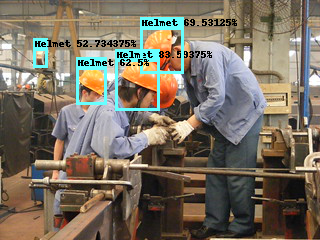

Evaluating: /content/drive/MyDrive/validate_img/image_2.jpg
Helmet 89.453125%
Helmet 71.484375%
Head 64.84375%
Helmet 62.5%
Head 52.734375%


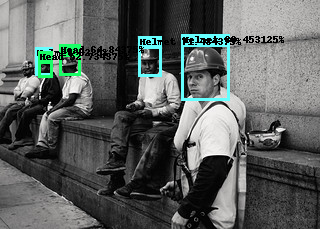

Evaluating: /content/drive/MyDrive/validate_img/image_3.jpg
Helmet 80.859375%


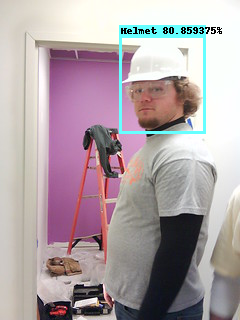

Evaluating: /content/drive/MyDrive/validate_img/image_4.jpg
Helmet 69.53125%
Head 64.84375%


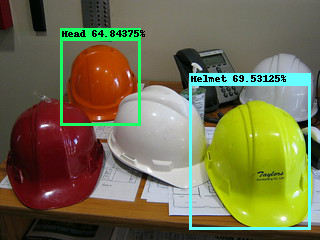

Evaluating: /content/drive/MyDrive/validate_img/image_5.jpg
Helmet 77.34375%
Helmet 77.34375%
Helmet 75.390625%
Helmet 73.4375%
Helmet 62.5%
Helmet 57.8125%


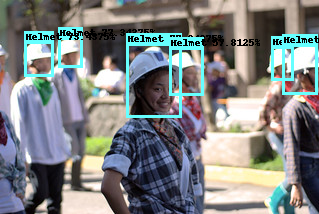

Evaluating: /content/drive/MyDrive/validate_img/image_6.jpg
Helmet 87.5%
Helmet 69.53125%
Helmet 69.53125%
Helmet 60.15625%
Helmet 52.734375%


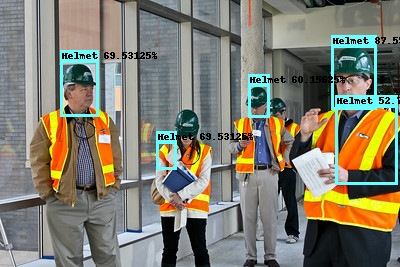

In [46]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = tf.lite.Interpreter(OUTPUT_DIR + '/ssdlite_mobiledet_hard_hat.tflite')
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()

  boxes= interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  num_detections = interpreter.get_tensor(output_details[3]['index'])[0]

  return boxes, classes, scores

test_image_paths = [os.path.join('/content/drive/MyDrive/validate_img', 'image_{}.jpg'.format(i)) for i in range(1, 7)]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.array(resized_image.getdata()).reshape((height, width, 3)).astype(np.uint8)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  # Draw results on image
  colors = {0:(25, 255, 102), 1:(102, 255, 255), 2:(255,255,100)}
  labels = read_label_file(OUTPUT_DIR + '/labels_2.txt')
  for i in range(len(boxes)):
    if scores[i] > 0.5:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i]) + 1] + ' ' + str(scores[i]*100) + '%'
      print(text)
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)

# **Real-time detection**

In [47]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [48]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [49]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [50]:
from datetime import datetime
from PIL import Image as myImage

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

In [55]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
width = 640
height = 480
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    cv2.imwrite("filename.jpg", frame)
    image = myImage.open("filename.jpg")
    resized_image = image.resize((320, 320))
    np_image = np.asarray(resized_image)
    input_tensor = np.expand_dims(np_image, axis=0)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([height, width, 4], dtype=np.uint8)

    # Run inference
    start = datetime.now()
    boxes, classes, scores = run_inference(interpreter, input_tensor)
    end = datetime.now()
    duration = end - start
    #print('INFERENCE TIME:', str(duration.microseconds/1000), " ms")

    for i in range(len(boxes)):
      if scores[i] > .6:
        ymin = int(max(1, (boxes[i][0] * height)))
        xmin = int(max(1, (boxes[i][1] * width)))
        ymax = int(min(height, (boxes[i][2] * height)))
        xmax = int(min(width, (boxes[i][3] * width)))

        bbox_array = cv2.rectangle(bbox_array, (xmin, ymin), (xmax, ymax), colors[int(classes[i])], 1)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(labels[int(classes[i]) + 1], float(scores[i])),
                        (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.4,
                        colors[int(classes[i])], 1)
        bbox_array = cv2.putText(bbox_array, "{}{:.2f}{}".format("INFERENCE TIME: ", float(duration.microseconds/1000), " ms"),
                        (100,300), cv2.FONT_HERSHEY_SIMPLEX, 0.4,
                        (255, 0, 0), 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>